In [1]:
from google.colab import drive

# Bağlantı oluştur
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/creating_new_face_with_100_gan")

In [3]:
%ls

gan_100.ipynb  gan_links.ipynb  photos_100/  res2/  trainnig_visual.gif


In [4]:
import numpy as np
import pandas as pd






import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/creating_new_face_with_100_gan'):
    for filename in filenames:
        print(os.path.join(dirname, filename))







from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

/content/drive/My Drive/creating_new_face_with_100_gan/gan_100.ipynb
/content/drive/My Drive/creating_new_face_with_100_gan/gan_links.ipynb
/content/drive/My Drive/creating_new_face_with_100_gan/trainnig_visual.gif
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/45B62D96-1C4A-4BB5-813B-232886EA8932.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/9B1AB0F0-3D4C-4A32-AE3C-996A01B7197B.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/18C990A7-83F9-4392-971F-109D634D743A.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/19C97FE4-5217-42F6-A9A5-8D05430E26F3.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/9C7993B8-063C-4FEF-BB07-E186A304520F.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/82E5778C-4FE1-444A-9AF8-7C8572EF556C.jpg
/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/74C895AB-BCB6-4E1C-BD

In [5]:
!pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 50.8 MB/s eta 0:00:00


In [6]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pyheif

PIC_DIR = f'/content/drive/My Drive/creating_new_face_with_100_gan/photos_100/178-218/'

IMAGES_COUNT = 69

ORIG_WIDTH = 218
ORIG_HEIGHT = 178
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-6-a1129b61170c>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
100%|██████████| 69/69 [00:16<00:00,  4.07it/s]


In [7]:
images = np.array(images) / 255
print(images.shape)

(69, 128, 128, 3)


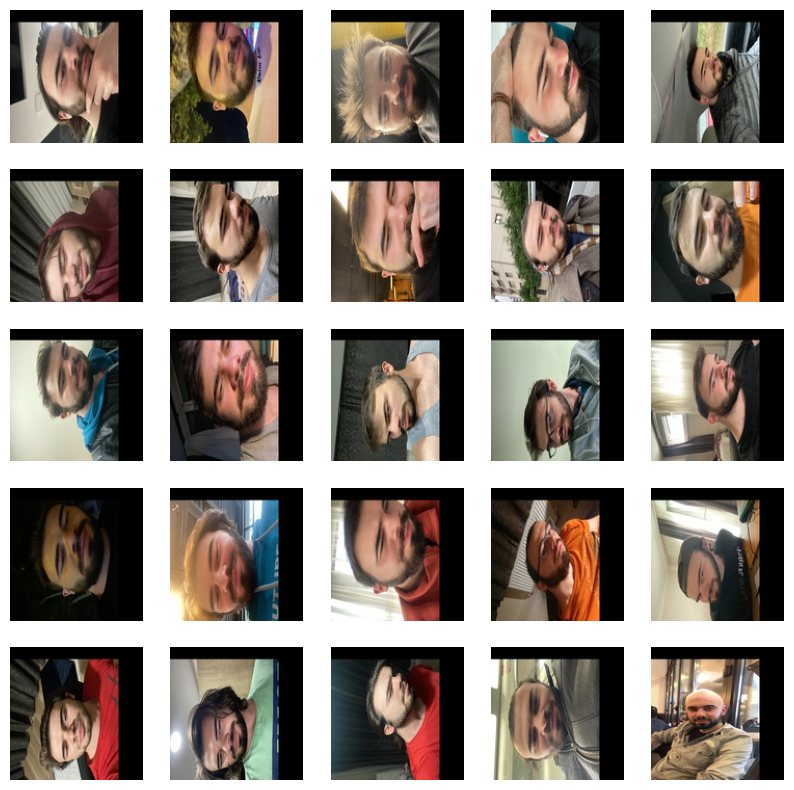

In [8]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.savefig('first_25_images.png')

plt.show()

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, Dropout
from tensorflow.keras.optimizers import RMSprop

In [10]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator


In [11]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        learning_rate = .001,
        clipvalue=1.0,
        weight_decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [12]:
from tensorflow.keras.utils import model_to_dot

from IPython.display import Image


In [13]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

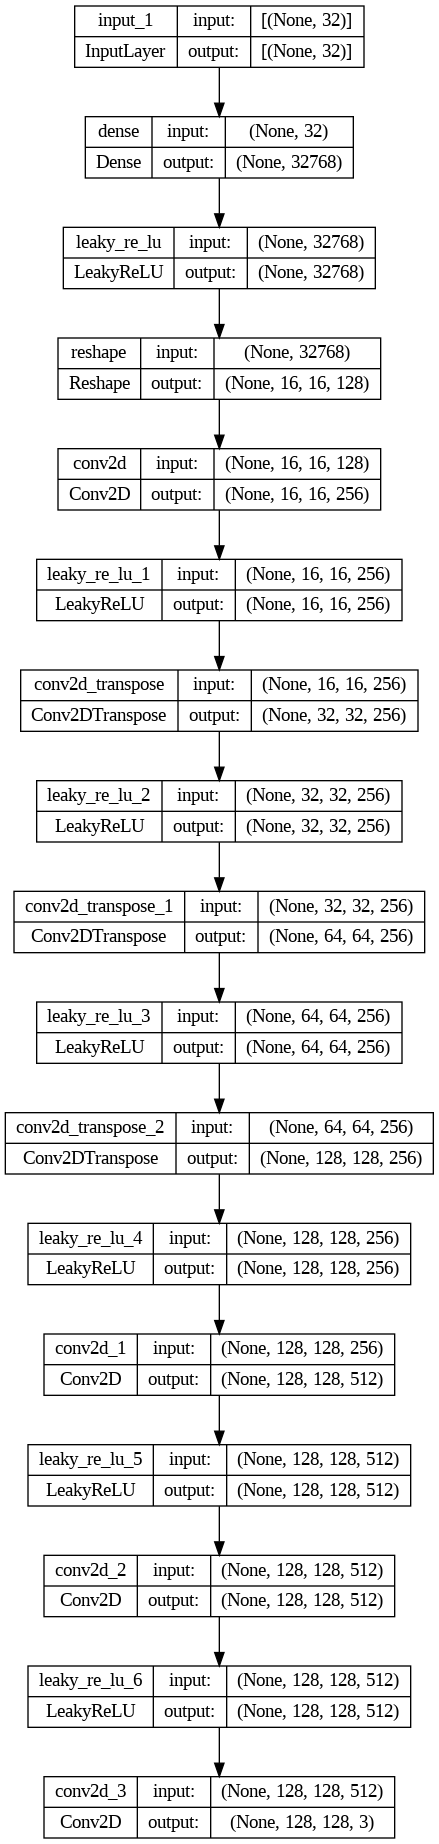

In [14]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [15]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

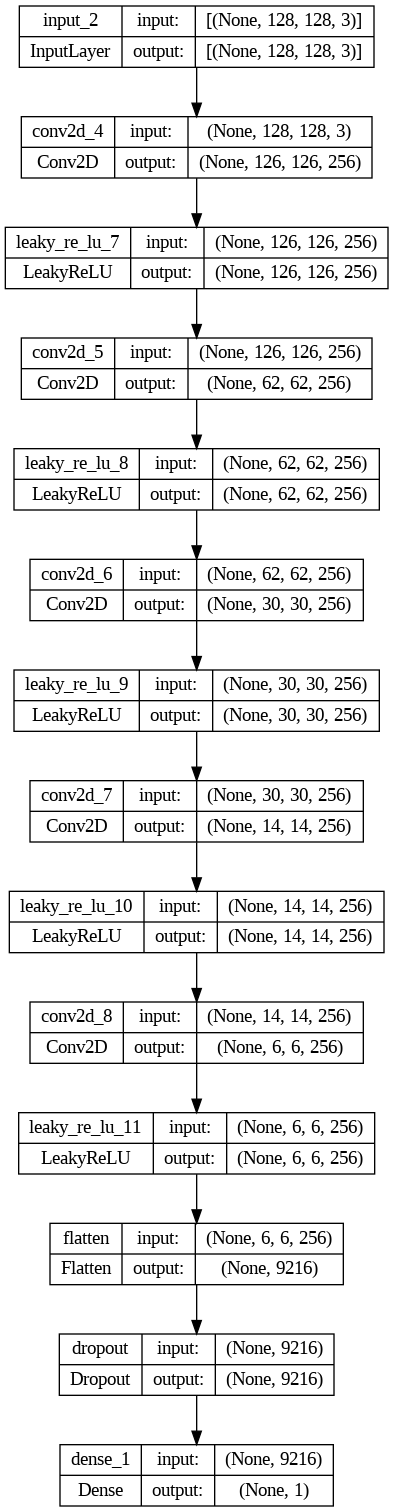

In [16]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [17]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [18]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(
    learning_rate=0.0001,
    clipvalue=1.0,
    weight_decay=1e-8
)

gan.compile(
    optimizer=optimizer,
    loss='binary_crossentropy'
)


In [19]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19165700 (73.11 MB)
Trainable params: 14953987 (57.04 MB)
Non-trainable params: 4211713 (16.07 MB)
_________________________________________________________________


In [ ]:
%pwd

'/content/drive/MyDrive/creating_new_face_with_100_gan'

In [ ]:
###
import time
iters = 25
batch_size = 4

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 4
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 5 == 4:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

1/1 [==============================] - 27s 27s/step
5/25: d_loss: 0.0422,  a_loss: 10.9310.  (153.5 sec)
1/1 [==============================] - 27s 27s/step
10/25: d_loss: 7.5958,  a_loss: 0.0000.  (132.1 sec)
1/1 [==============================] - 30s 30s/step
15/25: d_loss: 78.1019,  a_loss: 0.0023.  (136.5 sec)
1/1 [==============================] - 26s 26s/step
20/25: d_loss: 0.0600,  a_loss: 5.1074.  (127.9 sec)
1/1 [==============================] - 26s 26s/step
25/25: d_loss: 2.1831,  a_loss: 0.5699.  (127.9 sec)
1/1 [==============================] - 113s 113s/step


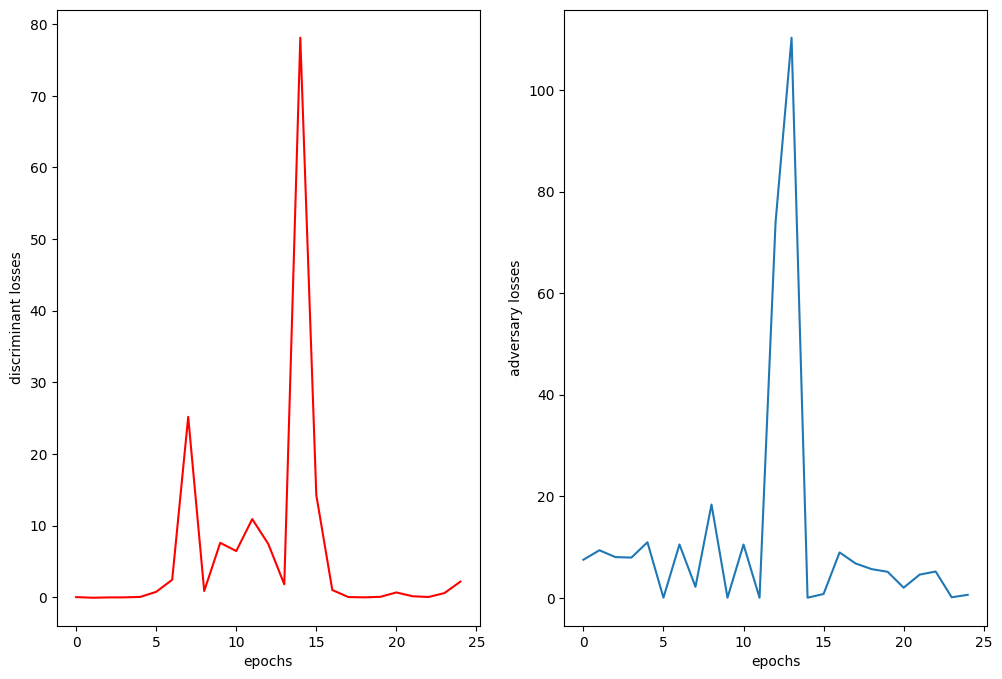

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
!pip install imageio

In [ ]:
try:
    import shutil
    print("shutil modülü mevcut.")
except ImportError:
    print("shutil modülü bulunamadı.")


shutil modülü mevcut.


In [ ]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)


<ipython-input-40-37747a2ce685>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
